In [2]:
import os
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data_dir = 'ohlc_data'
symbols = ['EURUSD', 'AUDUSD', 'GBPUSD']

for i in symbols:
    data_path = os.path.join(os.getcwd(), data_dir, i, 'H1_'+i+'_2015.csv')
    print(data_path)
    dt = pd.read_csv(data_path, index_col=0)
    
    # Convert Unix timestamps to datetime format
    dt['Time'] = pd.to_datetime(dt['time'], unit='s')
    
    if 'volume' not in dt.columns:
        dt.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'tick_volume':'Volume'}, inplace=True)
    else:
        dt.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace=True)

#     data = pd.read_csv(data_path, parse_dates=["Date"], index_col="Date")
    break

data = dt
data['Date'] = data['Time']

D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\H1_EURUSD_2015.csv


In [19]:
len(dt)

61938

In [3]:
df=data


start = 0
end = len(dt)
# end = 5000
# Assuming 'df' is your DataFrame and it contains 'Date' and 'Close' columns
df = df.iloc[start:end].reset_index(drop=True)  # Reset index after slicing

# Identify local maxima and minima
max_signal_indices = argrelextrema(df['Close'].values, np.greater, order=50)[0]
min_signal_indices = argrelextrema(df['Close'].values, np.less, order=50)[0]

# Initialize Signal column
df['Signal'] = 0
df.loc[max_signal_indices, 'Signal'] = 1  # Sell Signal
df.loc[min_signal_indices, 'Signal'] = 2   # Buy Signal


# # Modify signals to extend their effect for the next 10 points
# extension_length = 15
# for idx in df[df['Signal'] != 0].index:  # Iterate over non-zero signals
#     signal_value = df.loc[idx, 'Signal']  # Get the signal value (1 or -1)
#     # Update the next `extension_length` zeros to the current signal
#     end_idx = min(idx + extension_length, len(df))  # Ensure we don't exceed bounds
#     for i in range(idx + 1, end_idx):
#         if df.loc[i, 'Signal'] == 0:  # Only alter zero signals
#             df.loc[i, 'Signal'] = signal_value


# # # Debugging Info
# # print(f"Total Original Sell Signals: {len(max_signal_indices)}")
# # print(f"Total Original Buy Signals: {len(min_signal_indices)}")
# # print(f"Filtered Signals After Extension: {df['Signal'].value_counts()}")
            
            
# # Threshold_distance = 25
# # # mv_avg = df['Close'].rolling(window=15).mean()

# # # Filtering consecutive signals
# # signal_indices = df[df['Signal'] != 0].index  # Get indices where signals exist
# # for i in range(1, len(signal_indices)):
# #     current_index = signal_indices[i]
# #     previous_index = signal_indices[i - 1]
    
# #     # Check for consecutive opposite signals within a short distance (e.g., 25 candles)
# #     if abs(current_index - previous_index) <= Threshold_distance and \
# #             df.loc[current_index, 'Signal'] == df.loc[previous_index, 'Signal']:
# #                 df.loc[current_index, 'Signal'] = 0  # Convert to Buy Signal


# # # Debugging Info
# # print(f"Total Original Sell Signals: {len(max_signal_indices)}")
# # print(f"Total Original Buy Signals: {len(min_signal_indices)}")
# # print(f"Filtered Signals: {df['Signal'].value_counts()}")

# # Modify signals to extend their effect 3 steps **before** each signal
# extension_length = 5
# for idx in df[df['Signal'] != 0].index:  # Iterate over non-zero signals
#     signal_value = df.loc[idx, 'Signal']  # Get the signal value (1 or -1)
#     # Update the previous `extension_length` zeros to the current signal
#     start_idx = max(idx - extension_length, 0)  # Ensure we don’t go below index 0
#     df.loc[start_idx, 'Signal'] = 0

# # Debugging Info
# print(f"Total Original Sell Signals: {len(max_signal_indices)}")
# print(f"Total Original Buy Signals: {len(min_signal_indices)}")
# print(f"Filtered Signals After Propagation: {df['Signal'].value_counts()}")

# Propagate signals consecutively
current_signal = 0
for idx in df.index:
    if df.loc[idx, 'Signal'] != 0:
        current_signal = df.loc[idx, 'Signal']  # Update the current signal
    df.loc[idx, 'Signal'] = current_signal  # Propagate the current signal

# Debugging Info
print(f"Total Original Sell Signals: {len(max_signal_indices)}")
print(f"Total Original Buy Signals: {len(min_signal_indices)}")
print(f"Filtered Signals After Propagation: {df['Signal'].value_counts()}")



# Calculate Bollinger Bands
window = 7  # Rolling window size for Bollinger Bands
std_dev_multiplier = 2
df['Moving_Avg'] = df['Close'].rolling(window=window).mean()
df['Upper_Band'] = df['Moving_Avg'] + (std_dev_multiplier * df['Close'].rolling(window=window).std())
df['Lower_Band'] = df['Moving_Avg'] - (std_dev_multiplier * df['Close'].rolling(window=window).std())

# Replace signals with 0 if they remain within the Bollinger Bands squeezed area
for idx in df.index:
    if df.loc[idx, 'Signal'] != 0:
        if df.loc[idx, 'Close'] >= df.loc[idx, 'Lower_Band'] and df.loc[idx, 'Close'] <= df.loc[idx, 'Upper_Band']:
            df.loc[idx, 'Signal'] = 0

# Debugging Info
print(f"Total Original Sell Signals: {len(max_signal_indices)}")
print(f"Total Original Buy Signals: {len(min_signal_indices)}")
print(f"Filtered Signals After Propagation: {df['Signal'].value_counts()}")

Total Original Sell Signals: 398
Total Original Buy Signals: 397
Filtered Signals After Propagation: Signal
1    30957
2    30880
0      101
Name: count, dtype: int64
Total Original Sell Signals: 398
Total Original Buy Signals: 397
Filtered Signals After Propagation: Signal
0    59856
2     1060
1     1022
Name: count, dtype: int64


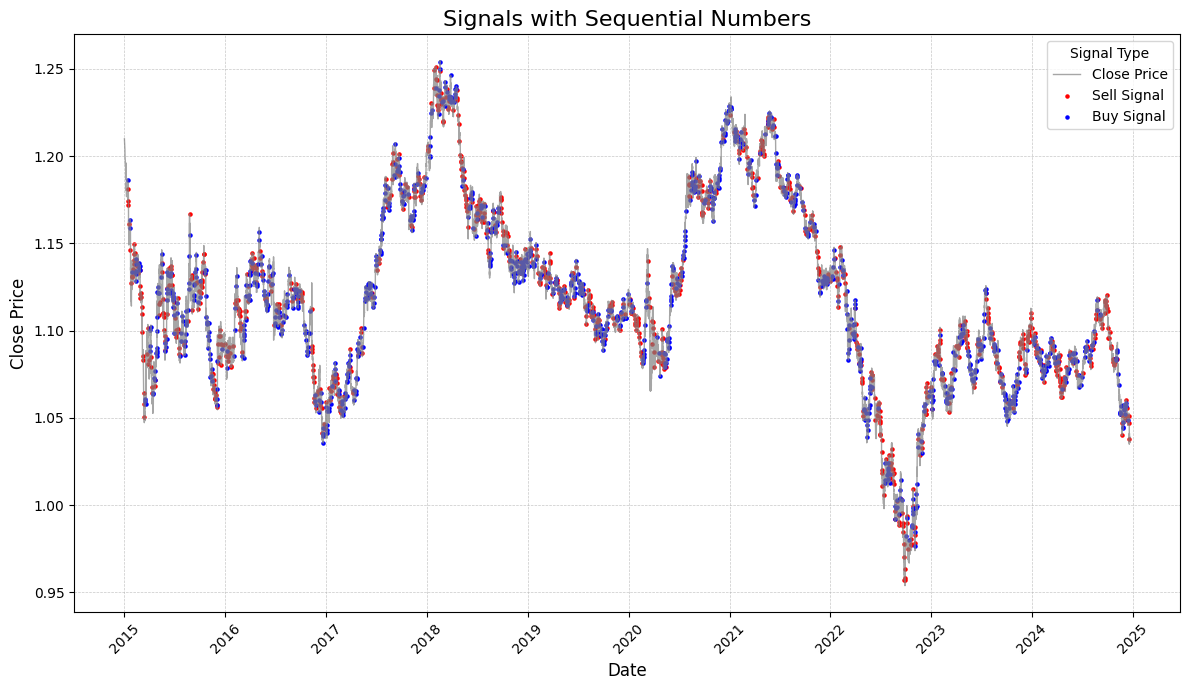

In [5]:


# Plot Close Prices and signals
plt.figure(figsize=(12, 7))
plt.plot(df['Date'], df['Close'], c='gray', alpha=0.7, label='Close Price', linewidth=1)
# plt.plot(df['Date'], df['Lower_Band'], c='red', alpha=0.7, label='Lower_Band', linewidth=1)
# plt.plot(df['Date'], df['Upper_Band'], c='blue', alpha=0.7, label='Upper_Band', linewidth=1)


# Combine Buy and Sell Signals into one DataFrame
signals = df[df['Signal'] != 0]  # Filter rows with non-zero signals (buy/sell)


# Plot Final Sell Signals
sell_signals = signals[signals['Signal'] == 1]
plt.scatter(sell_signals['Date'], sell_signals['Close'], c='red', label='Sell Signal', marker='o', s=5)


# Plot Final Buy Signals
buy_signals = signals[signals['Signal'] == 2]
plt.scatter(buy_signals['Date'], buy_signals['Close'], c='blue', label='Buy Signal', marker='o', s=5)


# Add sequential numbering for all signals with adjusted spacing
# for idx, row in signals.iterrows():
#     plt.annotate(
#         str(idx+start),  # Display the original index from df
#         (row['Date'], row['Close']),
#         textcoords="offset points",
#         xytext=(5, 10),  # Offset the text slightly above and to the right of the point
#         ha='center',
#         fontsize=8,
#         color='black',
#         arrowprops=dict(arrowstyle="->", color='gray', lw=0.5)  # Optional: Add arrows for clarity
#     )


# Chart Customization
plt.title('Signals with Sequential Numbers', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)


# Set date format and tick frequency
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to monthly intervals
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format tick labels as Year-Month
# plt.gca().xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))  # Add weekly minor ticks


plt.xticks(rotation=45, fontsize=10)


# Optional: Adjust Y-axis grid density
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)


plt.legend(title='Signal Type')
plt.tight_layout()
plt.show()




In [5]:
df.Signal.unique()


array([0, 2, 1], dtype=int64)

In [4]:
# Create the file name
f_name = f"{start}_{end}.csv"

# Drop specific columns if they exist in the DataFrame
columns_to_drop = ['time', 'spread', 'real_volume']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Adjust index (assuming 'start' is numeric)
df.index = df.index + start

# Save the DataFrame to a CSV file
df.to_csv(os.path.join(os.getcwd(), data_dir, f_name))

print(f"DataFrame saved to {f_name}")

DataFrame saved to 0_61938.csv


In [47]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Time', 'Date', 'Signal'], dtype='object')

<Axes: >

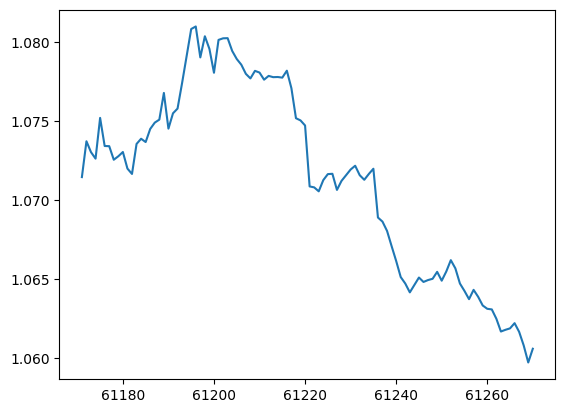

In [46]:
df['Close'].iloc[61171-start:61171+100-start].plot()

In [28]:
# Extract the specified range of data
subset = df['Close'].iloc[46136-start:46282-start]

# Find the 3 highest points and their indices
top_3_highest = subset.nlargest(3)
top_3_smallest = subset.nsmallest(3)

# Display the 3 highest points and their indices
print(top_3_highest, top_3_smallest)


46155    1.07333
46146    1.07286
46154    1.07274
Name: Close, dtype: float64 46255    1.03809
46254    1.03848
46274    1.03848
Name: Close, dtype: float64


In [109]:
for i in signal_indices[-15:]:
    print(i, df['Signal'].iloc[i])

4050 1
4088 -1
4128 1
4177 -1
4184 1
4291 1
4342 -1
4374 1
4432 1
4527 -1
4618 1
4684 1
4845 -1
4913 1
4984 -1


In [49]:
import pandas as pd
import os

data_dir = 'ohlc_data'
data_path = os.path.join(os.getcwd(), data_dir)
    

# List of all CSV files to merge
csv_files = [
    "10000_15000.csv", "15000_20000.csv", "1st_5000.csv",
    "20000_25000.csv", "25000_30000.csv", "30000_35000.csv",
    "35000_40000.csv", "40000_45000.csv", "45000_50000.csv",
    "50000_55000.csv", "5000_10000.csv", "55000_60000.csv",
    "60000_61938.csv"
]

# Initialize an empty list to store DataFrames
dataframes = []

# Read and append each CSV file to the list
for file in csv_files:
    df = pd.read_csv(os.path.join(data_path, file))
    dataframes.append(df)

# Concatenate all DataFrames vertically (stacking columns)
merged_df = pd.concat(dataframes, ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv("merged_data.csv", index=False)

print("All CSV files have been merged and saved as 'merged_data.csv'.")


All CSV files have been merged and saved as 'merged_data.csv'.


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Step 1: Load the merged data file
merged_data = pd.read_csv("merged_data.csv")

# Ensure the 'Date' column is parsed as datetime for proper plotting
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Step 2: Split data into chunks of 5000 rows
chunk_size = 5000
num_chunks = len(merged_data) // chunk_size + (1 if len(merged_data) % chunk_size != 0 else 0)

# Create output directory for charts
os.makedirs("charts", exist_ok=True)

# Step 3: Generate charts for each chunk
for i in range(num_chunks):
    # Slice the DataFrame for the current chunk
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(merged_data))
    chunk = merged_data.iloc[start_idx:end_idx]
    
    # Plot Close Prices
    plt.figure(figsize=(12, 6))
    plt.plot(chunk['Date'], chunk['Close'], label='Close Price', color='gray', linewidth=1)
    
    # Plot Buy Signals (Signal == 1)
    buy_signals = chunk[chunk['Signal'] == 1]
    plt.scatter(buy_signals['Date'], buy_signals['Close'], label='Buy Signal', color='blue', marker='o', s=50)
    
    # Plot Sell Signals (Signal == -1)
    sell_signals = chunk[chunk['Signal'] == -1]
    plt.scatter(sell_signals['Date'], sell_signals['Close'], label='Sell Signal', color='red', marker='o', s=50)
    
    # Add chart details
    plt.title(f"Close Prices and Signals (Rows {start_idx} to {end_idx - 1})", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Close Price", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    
    # Step 4: Save the chart
    chart_filename = f"charts/close_prices_signals_{start_idx}_{end_idx - 1}.png"
    plt.savefig(chart_filename)
    plt.close()

print(f"Charts for all chunks have been saved in the 'charts' directory.")


Charts for all chunks have been saved in the 'charts' directory.


Final Portfolio Value: $442258.32
Cumulative Return: 342.26%
Sharpe Ratio: -2.03
Maximum Drawdown: -7.26%


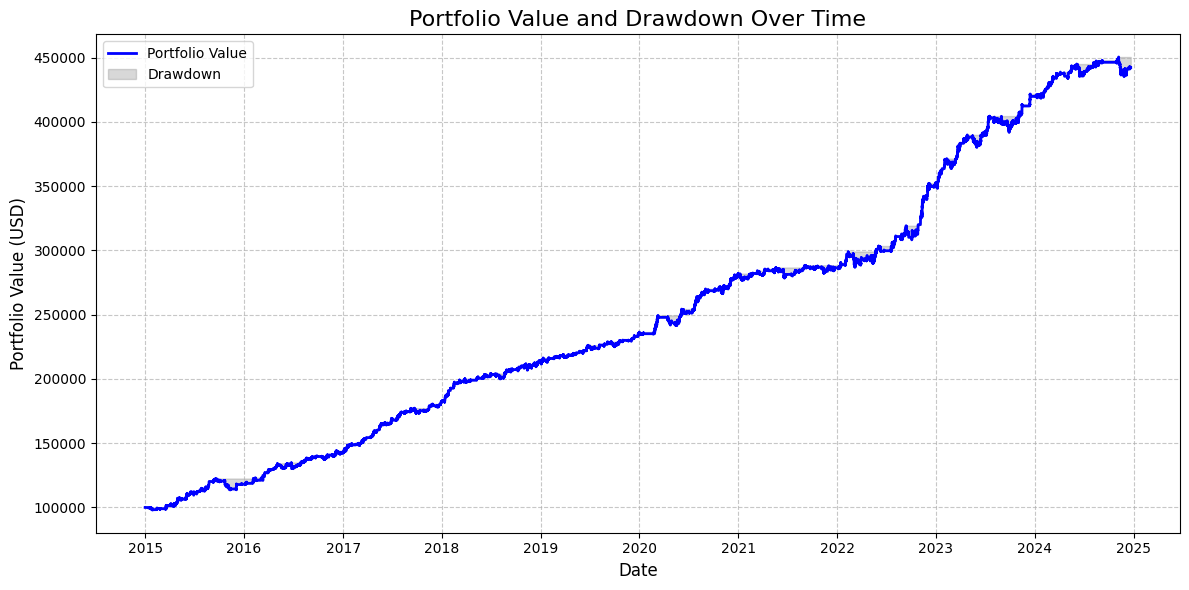

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = 'ohlc_data'
dataset = '0_61938.csv'
dataset_file = os.path.join(os.getcwd(), data_dir, dataset)
# Load the dataset
# data = pd.read_csv("merged_data.csv")
data = pd.read_csv(dataset_file)

# Ensure 'Date' column is parsed as datetime
data['Date'] = pd.to_datetime(data['Date'])

# Initialize Portfolio
starting_capital = 100000  # Starting capital in USD
cash = starting_capital  # Cash available
stock_holdings = 0  # Number of shares held
portfolio_values = []  # To track portfolio value over time
dates = []  # To track dates for plotting

# Simulate trading
for idx, row in data.iterrows():
    price = row['Close']  # Current stock price
    signal = row['Signal']  # Current signal (1, -1, or 0)

    # Handle Buy Signal
    if signal == 2:  # Buy
        shares_to_buy = cash // price  # Buy as many shares as possible
        cash -= shares_to_buy * price
        stock_holdings += shares_to_buy

    # Handle Sell Signal
    elif signal == 1:  # Sell
        cash += stock_holdings * price  # Sell all shares
        stock_holdings = 0

    # Calculate current portfolio value
    portfolio_value = cash + stock_holdings * price
    portfolio_values.append(portfolio_value)
    dates.append(row['Date'])

# Add the portfolio values to the DataFrame
data['Portfolio Value'] = portfolio_values

# Calculate Daily Returns
data['Daily Return'] = data['Portfolio Value'].pct_change()

# Sharpe Ratio
risk_free_rate = 0.03 / 252  # Convert annual risk-free rate to daily
excess_daily_return = data['Daily Return'] - risk_free_rate
sharpe_ratio = excess_daily_return.mean() / excess_daily_return.std() * np.sqrt(252)

# Drawdown
data['Peak'] = data['Portfolio Value'].cummax()
data['Drawdown'] = (data['Portfolio Value'] - data['Peak']) / data['Peak']
max_drawdown = data['Drawdown'].min()

# Cumulative Return
final_portfolio_value = portfolio_values[-1]
cumulative_return = (final_portfolio_value - starting_capital) / starting_capital

# Display Results
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Cumulative Return: {cumulative_return * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

# Plot Portfolio Performance
plt.figure(figsize=(12, 6))
plt.plot(dates, portfolio_values, label="Portfolio Value", color='blue', linewidth=2)
plt.fill_between(dates, portfolio_values, data['Peak'], color='gray', alpha=0.3, label='Drawdown')
plt.title("Portfolio Value and Drawdown Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value (USD)", fontsize=12)
plt.grid(linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


Average Daily Return: 0.00%
Average Monthly Return: 1.29%
Average Yearly Return: 16.09%


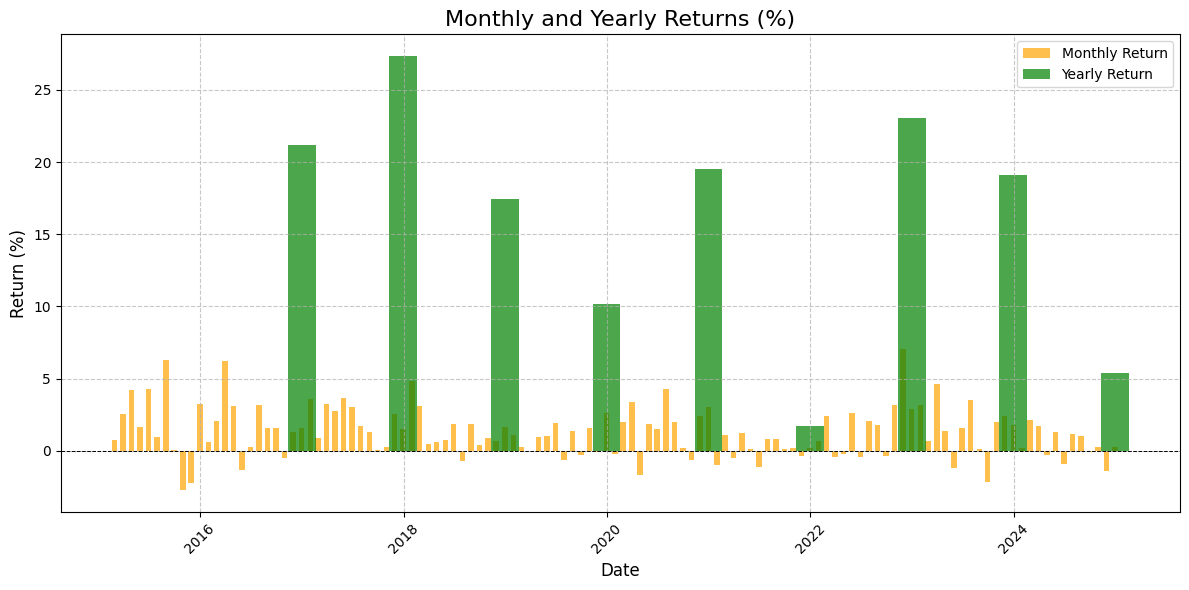

In [8]:
# Ensure 'Date' is the index for resampling
data.set_index('Date', inplace=True)

# Daily Returns
data['Daily Return'] = data['Portfolio Value'].pct_change()
average_daily_return = data['Daily Return'].mean()

# Monthly Returns
monthly_returns = data['Portfolio Value'].resample('M').ffill().pct_change()
average_monthly_return = monthly_returns.mean()

# Yearly Returns
yearly_returns = data['Portfolio Value'].resample('Y').ffill().pct_change()
average_yearly_return = yearly_returns.mean()

# Display Results
print(f"Average Daily Return: {average_daily_return * 100:.2f}%")
print(f"Average Monthly Return: {average_monthly_return * 100:.2f}%")
print(f"Average Yearly Return: {average_yearly_return * 100:.2f}%")

# Optional: Plot returns using bar charts
plt.figure(figsize=(12, 6))

# Bar chart for monthly returns
plt.bar(
    monthly_returns.index, 
    monthly_returns * 100, 
    color='orange', 
    alpha=0.7, 
    label='Monthly Return', 
    width=20  # Adjust bar width for better visibility
)

# Bar chart for yearly returns
plt.bar(
    yearly_returns.index, 
    yearly_returns * 100, 
    color='green', 
    alpha=0.7, 
    label='Yearly Return', 
    width=100  # Adjust bar width for yearly data
)

# Add a horizontal line at 0
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)

# Customize the plot
plt.title("Monthly and Yearly Returns (%)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Return (%)", fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Load Dataset
data_dir = 'ohlc_data'
dataset = '0_61938.csv'
dataset_file = os.path.join(os.getcwd(), data_dir, dataset)
data = pd.read_csv(dataset_file)

# Ensure 'Date' column is parsed as datetime
data['Date'] = pd.to_datetime(data['Date'])

# Portfolio Settings
starting_capital = 100000  # Starting capital in USD
cash = starting_capital  # Cash available
stock_holdings = 0  # Number of shares held
equity_curve = []  # Track equity curve
balance_curve = []  # Track balance (realized gains)
drawdowns = []
dates = []  # Store date for plotting

# Trade Log (MT4-Style)
trade_log = []  # Store trade details
open_trade = None  # Track open trade

# Simulate Trading
for idx, row in data.iterrows():
    price = row['Close']  # Current stock price
    signal = row['Signal']  # Buy(1), Sell(-1), Hold(0)
    
    # Execute Buy Order
    if signal == 2 and cash >= price:
        shares_to_buy = cash // price
        if shares_to_buy > 0:
            open_trade = {'Entry Date': row['Date'], 'Entry Price': price, 'Shares': shares_to_buy}
            cash -= shares_to_buy * price
            stock_holdings += shares_to_buy
    
    # Execute Sell Order
    elif signal == 1 and stock_holdings > 0:
        if open_trade:
            # Calculate PnL
            trade_pnl = (price - open_trade['Entry Price']) * stock_holdings
            trade_log.append({
                'Entry Date': open_trade['Entry Date'],
                'Exit Date': row['Date'],
                'Entry Price': open_trade['Entry Price'],
                'Exit Price': price,
                'Shares': stock_holdings,
                'PnL': trade_pnl
            })
        
        # Close Position
        cash += stock_holdings * price
        stock_holdings = 0
        open_trade = None  # Reset trade

    # Calculate Portfolio Values
    equity = cash + (stock_holdings * price)  # Real-time equity
    balance = cash  # Realized balance (without open positions)
    
    equity_curve.append(equity)
    balance_curve.append(balance)
    dates.append(row['Date'])

    # Track Drawdowns
    peak = max(equity_curve)  # Highest equity point
    drawdowns.append((equity - peak) / peak)

# Convert Trade Log to DataFrame
trade_df = pd.DataFrame(trade_log)

# Performance Metrics
total_trades = len(trade_df)
winning_trades = trade_df[trade_df['PnL'] > 0]
losing_trades = trade_df[trade_df['PnL'] <= 0]
win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
avg_trade_return = trade_df['PnL'].mean() if total_trades > 0 else 0

# Sharpe Ratio
data['Daily Return'] = pd.Series(equity_curve).pct_change()
risk_free_rate = 0.03 / 252  # Daily risk-free rate
excess_daily_return = data['Daily Return'] - risk_free_rate
sharpe_ratio = excess_daily_return.mean() / excess_daily_return.std() * np.sqrt(252)

# Maximum Drawdown
max_drawdown = min(drawdowns) * 100  # Convert to percentage

# Final Portfolio Statistics
final_equity = equity_curve[-1]
cumulative_return = (final_equity - starting_capital) / starting_capital * 100

# Print Portfolio Statistics
print(f"Final Portfolio Value: ${final_equity:.2f}")
print(f"Cumulative Return: {cumulative_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate * 100:.2f}%")
print(f"Avg Trade Return: ${avg_trade_return:.2f}")

# Save trade log
trade_df.to_csv("trade_log.csv", index=False)




Final Portfolio Value: $442258.32
Cumulative Return: 342.26%
Sharpe Ratio: -2.03
Maximum Drawdown: -7.26%
Total Trades: 265
Win Rate: 71.32%
Avg Trade Return: $1291.54


In [50]:
# Replace None with 'Hold' in the Signal column
df['Signal'] = df['Signal'].fillna('Hold')

In [53]:
df['Signal'].value_counts()

Hold    61122
Buy       411
Sell      404
Name: Signal, dtype: int64

In [54]:
df.to_csv('Signal_EURUSD.csv')

In [70]:
# Create a copy of the Signal column
modified_signals = df['Signal'].values.copy()

# Initialize variables
previous_signal = None

# Iterate through the signals and modify them
for i in range(len(modified_signals)):
    if modified_signals[i] in ['Buy', 'Sell']:
        if previous_signal and previous_signal != modified_signals[i]:  # Transition detected
            modified_signals[i - 1] = 'Close'  # Insert "Close" before the current signal
        previous_signal = modified_signals[i]

# Assign the modified signals back to the DataFrame
df['Modified_Signal'] = modified_signals

# Print the modified signals for the first 200 rows
# print(df['Modified_Signal'].values[1:500])


In [72]:
print(df['Modified_Signal'].values[1:500])

['Hold' 'Hold' 'Sell' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Sell' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Close' 'Buy' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold

In [71]:
df['Modified_Signal']

1        Sell
2        Hold
3        Hold
4        Sell
5        Hold
         ... 
61933    Hold
61934    Hold
61935    Hold
61936    Hold
61937    Hold
Name: Modified_Signal, Length: 61937, dtype: object